# Lecture 14. Twice the fun with the 2D Fourier transform

## Instructions

Please work through this activity together in groups of 3-4. Along the way there will be code blocks to fill in, and conceptual questions to answer. Once you have completed all the sections, you have the **option** to submit (as a group) one copy of this worksheet. **This is not a mandatory assignment**. Instead, contributors to each submission will be granted 2 bonus points (points, not %) that can be "banked" and later applied to any assignment, quiz, or test during the term.

**Submission deadline**: Saturday at 23:59pm. Late submissions will not be considered for bonus points.

## Overview

So far, all the signals we've worked with in the course have been plain old 1-dimensional signals. However, signals come in many shapes and sizes, and the processing of 2-dimensional signals is something we encounter on a daily basis (basically, anytime we look at a screen).

In this hands-on "lecture", you'll learn a few basic techniques for processing 2D images. Similar to our audio processing exercise, we'll mostly be applying simple filters. After working through this notebook, you'll be able to:
 - define and compute the Fourier transform of two-dimensional signals
 - describe the role of a spectrum's magnitude and phase in image processing
 - apply simple filters to modify images in Python

Let's start by importing some useful libraries. Note that, for this exercise, you'll need to install the `scikit-image` package.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, color

## Part 1: mathematical expression of 2D signals

Everything we've done so far with Fourier analysis can be extended to multi-dimensional signals. As a starting point, let's consider what this looks like in continuous time. If a continuous-time signal is periodic, we can express it using a Fourier series. In 1D, this amounts to a linear combination of sines and cosines (or equivalently, of complex exponential signals) with integer multiples of a fundamental frequency:

$$
x(t) = \sum_{k=-\infty}^{\infty} c_k e^{jk\omega t} = a_0 + \sum_{k=1}^{\infty} a_k \cos(k \omega t) + \sum_{k=1}^{\infty} b_k \sin(k \omega t)
$$

The complex exponentials and trigonometric functions are *basis functions*, and we are expressing everything in terms of them.

In 2D, things are quite similar. Rather than expressing our signals as functions of time (since time is not 2D), let's instead consider continuous-time signals as functions over space. We'll write them as $f(x, y)$. Just like in 1D, periodic signals in 2D can be expressed as linear combinations of complex exponentials (or trig functions, if you prefer), but now there are two of everything (you might recognize these types of functions from your ODEs class, too):

$$
f(x, y) = \sum_{k=-\infty}^{\infty}\sum_{\ell=-\infty}^{\infty} c_{k,l}  \exp\left[j k \omega_x x\right] \exp\left[j \ell \omega_y y\right].
$$



In discrete time, for a periodic signal $f[x, y]$ with dimensions $M \times N$, we have

$$
f[x, y] = \sum_{k=0}^{M-1}\sum_{\ell=0}^{N-1} c_{k, \ell} \exp\left[j k \frac{2\pi}{M} x\right] \exp\left[j \ell \frac{2\pi}{N} y\right]
$$

Let's start by playing with some basis functions.

**Question 1.1**. Fill in the function below to implement a function that constructs discretized versions of a single basis function.

In [ ]:
def construct_2D_basis_function(k, M, l, N):
    """Create and return a 2D basis function.

    This function should return a new function, f(x, y), such that
        f(x, y) = exp(1j * k * (2 pi / M) * x) exp(1j * ky * (2 pi / N) * y)

    Args:
        k (int): index of the harmonic in the x direction
        M (int): period of the signal in the x direction
        l (int): index of the harmonic in the y direction
        N (int): period of the signal in the y direction

    Returns:
        Callable: a function that implements the f(x, y) described above.
        It should take two inputs, x and y, and return a single
        complex number.
    """
    def f(x,y):
      return np.exp(1j*k*(2*np.pi/M)*x)*np.exp(1j*l*(2*np.pi/N)*y)
    return f

It might seem a bit odd to express our function in this way. However this will come in handy for what we are going to do next.

**Question 1.2**. Construct and plot the real part of the following basis functions evaluated on a grid of points (provided below):
 - $k = 1$, $\ell = 0$
 - $k = 0$, $\ell = 1$
 - $k = 2$, $\ell = 3$
 - $k = 4$, $\ell = 6$

You can plot an array with `matplotlib` using the following code snippet:
```python
plt.matshow(my_matrix, cmap='gray')
```

*Pro tip*: with the provided grid, you should be able to do this without using any `for` loops!

In [ ]:
# Here we are defining a range of x and y coordinates over which to
# evaluate the functions. I've set M and N to be reasonably small and
# equal, but you can make them larger.
M = 50
N = 50

x_range = np.arange(0, M)
y_range = np.arange(0, N)

# np.meshgrid will tile the arrays such that what comes back
# will be two M x N grids of points represent the coordinates.
x_axis, y_axis = np.meshgrid(x_range, y_range)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


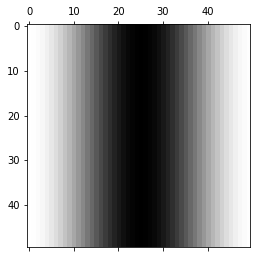

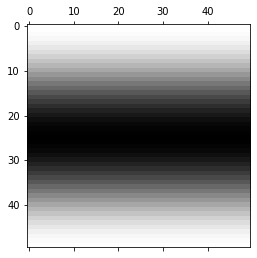

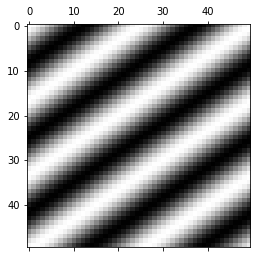

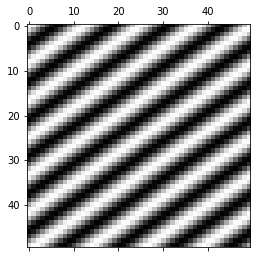

In [ ]:
def showPlot(k,l):
  function = construct_2D_basis_function(k,M,l,N)
  matrix = np.zeros((M,N))
  for x in x_range:
    for y in y_range:
      matrix[y,x] = function(x,y)

  plt.matshow(matrix, cmap='gray')

showPlot(1,0)
showPlot(0,1)
showPlot(2,3)
showPlot(4,6)

**Question 1.3**. Play a bit more with the function you made above, and see how the output image changes. What happens when you set a constant $k$ and start increasing $\ell$? Similarly, what happens if you hold $\ell$ constant and start increasing $k$? Describe your findings in the cell below before moving on.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


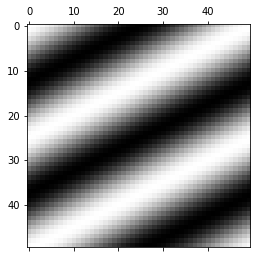

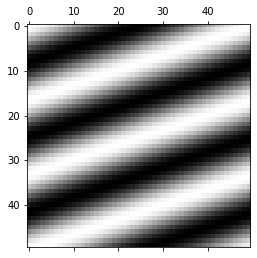

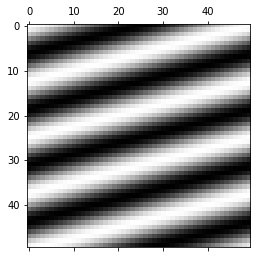

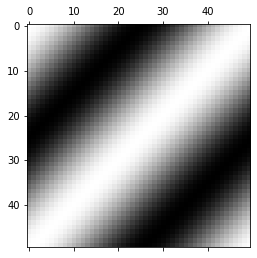

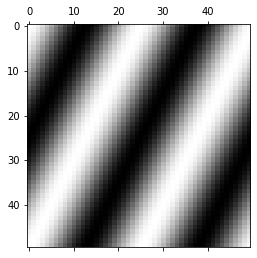

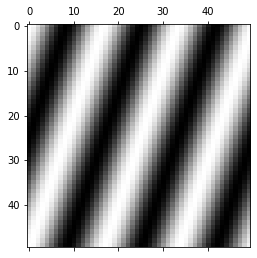

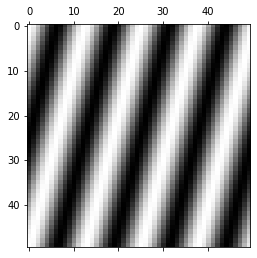

In [ ]:
showPlot(1,2)
showPlot(1,3)
showPlot(1,4)
showPlot(1,1)
showPlot(2,1)
showPlot(3,1)
showPlot(4,1)

We get more stipes for higher values. Keeping constant $k$ holds the angle constant with lower $k$ corresponding to a vertical angle and

## Part 2: 2D Fourier spectra

In class, we computed the 1D discrete Fourier transform,

$$
\tilde{X}[k] = \frac{1}{N} \sum_{n=0}^{N-1} x[n] \exp\left[- j k \frac{2\pi}{N} n\right]
$$

We saw that this is essentially a set of evenly-spaced samples of the more general discrete-time Fourier transform, which is a continuous function of frequency:

$$
X(e^{j\omega}) = \sum_{n=-\infty}^{\infty} x[n] \exp\left[- j \frac{2\pi}{N} n \right]
$$

The values of $X(e^{j\omega})$ and $\tilde{X}[k]$ tell us how much a particular frequency contributes to the signal.
This all generalizes to 2D. Suppose we have a 2D signal $f[x, y]$ with dimensions $M \times N$. Its discrete Fourier transform is given by

$$
\tilde{X}[k, \ell] = \frac{1}{M N} \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} f[x, y] \exp\left[- j k \frac{2\pi}{M} m\right] \exp\left[- j \ell \frac{2\pi}{N} n\right]
$$

**Question 2.1.** (a) Compute the Fourier spectrum of some of the basis functions you made in the previous section (head over to the [NumPy docs](https://numpy.org/doc/stable/reference/routines.fft.html) to find the right function for this purpose).

(b) Apply a *shift* so that the lowest-valued frequencies are in the middle (this is done for visual convenience)

(c) Plot the *magnitude* of the spectrum.

What do you see? Does this make sense?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


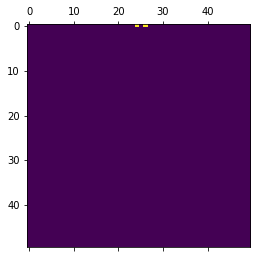

In [ ]:
def getFFT(k,l):
  func = construct_2D_basis_function(k,M,l,N)
  matrix = np.zeros((M,N))
  for x in x_range:
    for y in y_range:
      matrix[y,x] = func(x,y)
  matrix_1 = np.fft.fft2(matrix)
  matrix_1 = np.roll(matrix_1, N//2, axis=0)
  matrix_1 = np.roll(matrix_1, M//2, axis=1)
  return matrix_1
A = getFFT(1,25)
plt.matshow(A.real)

**Question 2.2.** Try summing together two different basis functions, then plot the magnitude of the resulting Fourier spectrum. Does your result make sense, based on the previous question?

Let's take a look now at an actual image. To get started, run the cells below to load it in and display it.

In [ ]:
# We will deliberately load this image in gray scale - we'll see some colour
# in the next section.
image = io.imread("keyboard-emoji.png", as_gray=True)

In [ ]:
# You can use either io.imshow, or plt.imshow/plt.matshow here with a grayscale colour
# io.imshow(image)
plt.imshow(image, cmap='gray')

**Question 2.3**. I've chosen this image for a very particular reason (and it's not just because I'm a pianist!). Take a close look, and consider your findings from problem 1. Why do you think I chose it?

**Question 2.4.** Compute the 2D Fourier transform of the image we loaded up. Apply a *shift* so that the lowest-valued frequencies are in the middle, then plot it's *magnitude* and *phase* components (note that this is not the same as its real and imaginary components).

**Question 2.5.** You might have noticed something weird here. In order to see more detail, try plotting the `log` of the magnitude plot. Does this give you any more information? What does it tell you about the structure of the original image?

**Question 2.6** Now let's apply the inverse 2D Fourier transform to reconstruct our original image (don't forget to apply the inverse shift!). Do this in three different ways, and plot the real and imaginary parts of the resulting image each time:
 - inverse transform the full spectrum
 - inverse transform the magnitude only
 - inverse transform the phase part only

For the latter two, recall that a complex number can be represented as $z = |z| e^{j \phi}$ where $\phi$ is the phase. The magnitude-only case should consider only $|z|$, while the phase part should consider $e^{j\phi}$ and not just $\phi$.

From this, describe the role does that the phase of the spectrum plays in describing an image.

Knowledge of the magnitude and phase content of an image's spectrum can be used for many processing tasks. Text alignment is one example; we won't go into the specifics, but I'll provide a basis for you to get started should you be interested in doing so.  

**Question 2.7.** Load up the image below, then plot the log magnitude and phase of its Fourier spectrum (remember to apply the shift to help with visualization). What do you see?

In [ ]:
text_image = io.imread("rotated-text.png", as_gray=True)

In [ ]:
io.imshow(text_image)

**Question 2.8. (Optional challenge)** As suggested in the image itself, one can determine an angle from the Fourier spectrum and apply a corrective rotation. Research some methods to accomplish this, and implement one of them. As a starting point, you might consider the [Hough transform](https://en.wikipedia.org/wiki/Hough_transform), which can detect lines in an image. See also [this paper](https://www.researchgate.net/publication/272825230_Hough_and_Fourier_Transforms_in_the_Task_of_Text_Lines_Detection).

## Part 3: life in colour

Colour images are of course more interesting. Depending on the file type, a colour image is stored as a set of 3 (or 4) 2D arrays which contain values describing their R (red), G (green), and B (blue) components respectively (the fourth channel, A (alpha) when present, is a measure of transparency). Load up the jpeg image below; it has only 3 channels. We'll plot them out separately. Then, we'll start applying some simple filters to modify the image.

In [ ]:
colour_image = io.imread("rainbow.jpeg")

In [ ]:
# Note the dimensions of this image
colour_image.shape

In [ ]:
io.imshow(colour_image)

In [ ]:
# We will plot these in gray scale, otherwise the default matplotlib
# cmap is yellow and purple
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
ax[0].imshow(colour_image[:,:,0], cmap='gray')
ax[0].set_title("R channel")
ax[1].imshow(colour_image[:,:,1], cmap='gray')
ax[1].set_title("G channel")
ax[2].imshow(colour_image[:,:,2], cmap='gray')
ax[2].set_title("B channel")

### Part 3a: it only gets butter from here

*Note: If you like, you can select an image of your choice moving forward. For convenience, choose one that's square, and work only with the RGB channels.*

The notion of highpass and lowpass filters exists in 2D as well. Rather than writing our own primitive, ideal filters, let's make use of what's already available in `scikit-image`. We'll look first at a type of filter called a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter). This is a type of non-ideal filter that attenuates frequencies more gradually than a "brick wall" ideal filter. The strength of attenuation, i.e., how quickly the frequency response drops to 0, is dictated by an *order parameter*. The greater the order, the steeper the drop. This has interesting consequences for the images.

**Question 3.1.** The Butterworth filter from `scikit-image` does not work automatically for multi-channel images. Complete the function below to apply it to every channel. See the [function documentation](https://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=butterworth#skimage.filters.butterworth) for a description of the parameters.

*Note*: you can, alternatively, use a decorator to adapt the filter directly, as is demonstrated [here](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_adapt_rgb.html#sphx-glr-auto-examples-color-exposure-plot-adapt-rgb-py).

In [ ]:
def apply_butterworth_filter(image, cutoff_frequency_ratio=0.01, high_pass=False, order=1):
    """Apply a Butterworth filter to a colour image.

    This function should wrap the skimage.filters.butterworth function
    so that it is applied to each channel of the image individually, and
    then the reconstructed image returned.

    Args:
        image (array): Array representing a multi-channel image.
        cutoff_frequency_ratio (float): Indicates the position of the frequency
            cutoff as a percentage of the length of the spectrum.
        high_pass (bool): If True, will act as a highpass filter. Otherwise, it
            will be a lowpass filter.
        order (float): The order of the filter; how quickly the frequency
            response drops to 0.

    Returns:
        array: A multi-channel image that has had the Butterworth filter
        applied to each channel indepedently.
    """
    return

**Question 3.2.** Try applying the filter to your image. How does it change when you apply a lowpass vs. a highpass filter? How is it affected by the order parameter?

### Part 3b: living on the edge

You may have noticed that using a highpass filter in the previous section seems to extract information about more localized features of an image, such as edges. Actual [edge detection](https://en.wikipedia.org/wiki/Edge_detection), however, is done using a different set of tools.
Loosely, it involves the application of some sort of differencing operation that compares the value of a pixel as with those of its neighbours.

For more information about edge detection, check out [this article in the `scikit-image` docs](https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html#sphx-glr-auto-examples-edges-plot-edge-filter-py).

**Question 3.3.** Select one of the 2D filters available in `scikit-image`.

(a) Briefly describe the mathematical operation that the filter performs.

(b) Write a function to apply it to all the image channels like you did with the Butterworth filter in the previous section. Does it do what you expect?

In [ ]:
def edge_detector(image):
    """Apply an edge detection filter to a colour image.

    This function should wrap a filter from skimage.filters so that it is
    applied to each channel individually, and the reconstructed image returned.

    Add keyword arguments to this function as needed.

    Args:
        image (array): Array representing a multi-channel image.

    Returns:
        array: A multi-channel image that has had an edge detection filter
        applied to each channel indepedently.
    """
    return

### Part 3c: face the facts

Just for fun, let's combine what you did in the previous two tasks to do something silly. For this, you will require images of two faces that have the same dimensions, and the faces in roughly the same position.

**Question 3.4 (Optional challenge)**. Load up the images, and filters to each of them individually. Then, combine the filtered images to make a "hybrid" face.

*If you would like to see a more sophisticated implementation of this, check out this [GitHub repository](https://github.com/LeviBorodenko/hybrid-face). It also contains a nice explanation of how it leverages Fourier analysis.*